In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("training on: ",device)

training on:  cuda


In [3]:
vgg = models.vgg19(pretrained = True).features.to(device).eval()

In [4]:
content_path = os.getcwd()+'/me2.jpg'
style_path = os.getcwd()+'/paint.jpg'

In [5]:
def openimage(image_path):
    input_transforms = transforms.Compose([transforms.Resize((500,500)),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.485, 0.456, 0.406),
                                                              (0.229, 0.224, 0.225))
                                          ])
    image = Image.open(image_path).convert('RGB')
    image = input_transforms(image).unsqueeze(0).to(device)
    return image

In [6]:
def convertimage(image):
    image = image.squeeze().permute(1,2,0).detach().to("cpu").numpy()
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    return (image.clip(0,1))

In [7]:
vgg #layers 0,5,10,19,21,28

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [8]:
content_layers = ['0','5','10','19','21','28']
style_layers = ['0','5','10','19','28']

In [9]:
def getcontent(image, model,layers):
    content = []
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            content.append(x)
    return content

In [10]:
def getstyle(content):
    _,d,h,w = content.shape
    content = content.view(d,h*w)
    gram = torch.mm(content, content.t())
    return gram

In [11]:
style_weights = [1.0,0.75,0.2,0.2,0.2]
alpha = 1
beta = 1e3

In [12]:
content_image = openimage(content_path)
style_image = openimage(style_path)
target_image = content_image.clone().requires_grad_(True).to(device)

In [13]:
content = getcontent(content_image, vgg, content_layers)
style = [getstyle(content) for content in getcontent(style_image, vgg, style_layers)]

epoch:0 loss:17259.212890625


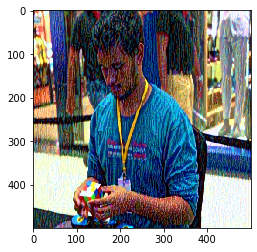

epoch:1 loss:17079.78125
epoch:2 loss:16889.65234375
epoch:3 loss:16671.865234375
epoch:4 loss:16497.111328125
epoch:5 loss:16293.28125
epoch:6 loss:16114.48828125
epoch:7 loss:15934.396484375
epoch:8 loss:15754.7587890625
epoch:9 loss:15579.15234375
epoch:10 loss:15400.357421875
epoch:11 loss:15226.70703125
epoch:12 loss:15057.1416015625
epoch:13 loss:14888.880859375
epoch:14 loss:14723.2529296875
epoch:15 loss:14559.0771484375
epoch:16 loss:14396.7666015625
epoch:17 loss:14237.5517578125
epoch:18 loss:14080.7822265625
epoch:19 loss:13926.1875
epoch:20 loss:13773.8291015625
epoch:21 loss:13623.564453125
epoch:22 loss:13475.5634765625
epoch:23 loss:13329.96875
epoch:24 loss:13186.5634765625
epoch:25 loss:13045.2060546875
epoch:26 loss:12905.85546875
epoch:27 loss:12768.521484375
epoch:28 loss:12633.30859375
epoch:29 loss:12500.197265625
epoch:30 loss:12369.0712890625
epoch:31 loss:12239.875
epoch:32 loss:12112.587890625
epoch:33 loss:11987.1875
epoch:34 loss:11863.7001953125
epoch:35 l

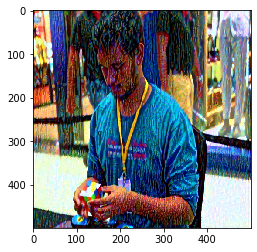

epoch:101 loss:6493.2568359375
epoch:102 loss:6442.10009765625
epoch:103 loss:6391.52294921875
epoch:104 loss:6341.5537109375
epoch:105 loss:6292.14013671875
epoch:106 loss:6243.27685546875
epoch:107 loss:6194.94677734375
epoch:108 loss:6147.15869140625
epoch:109 loss:6099.900390625
epoch:110 loss:6053.15869140625
epoch:111 loss:6006.95849609375
epoch:112 loss:5961.2734375
epoch:113 loss:5916.11474609375
epoch:114 loss:5871.4462890625
epoch:115 loss:5827.27490234375
epoch:116 loss:5783.5986328125
epoch:117 loss:5740.41748046875
epoch:118 loss:5697.71337890625
epoch:119 loss:5655.4658203125
epoch:120 loss:5613.69189453125
epoch:121 loss:5572.3564453125
epoch:122 loss:5531.466796875
epoch:123 loss:5491.03466796875
epoch:124 loss:5451.01708984375
epoch:125 loss:5411.42138671875
epoch:126 loss:5372.24951171875
epoch:127 loss:5333.50634765625
epoch:128 loss:5295.18505859375
epoch:129 loss:5257.28125
epoch:130 loss:5219.7802734375
epoch:131 loss:5182.67626953125
epoch:132 loss:5145.958007812

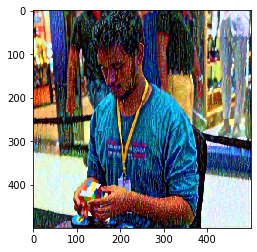

epoch:201 loss:3332.990966796875
epoch:202 loss:3314.584716796875
epoch:203 loss:3296.350341796875
epoch:204 loss:3278.27783203125
epoch:205 loss:3260.37060546875
epoch:206 loss:3242.6337890625
epoch:207 loss:3225.06103515625
epoch:208 loss:3207.6474609375
epoch:209 loss:3190.3935546875
epoch:210 loss:3173.295654296875
epoch:211 loss:3156.360107421875
epoch:212 loss:3139.576171875
epoch:213 loss:3122.94482421875
epoch:214 loss:3106.461181640625
epoch:215 loss:3090.1123046875
epoch:216 loss:3073.91796875
epoch:217 loss:3057.8583984375
epoch:218 loss:3041.932861328125
epoch:219 loss:3026.15869140625
epoch:220 loss:3010.525634765625
epoch:221 loss:2995.02783203125
epoch:222 loss:2979.6630859375
epoch:223 loss:2964.426025390625
epoch:224 loss:2949.3291015625
epoch:225 loss:2934.3544921875
epoch:226 loss:2919.509521484375
epoch:227 loss:2904.7890625
epoch:228 loss:2890.19921875
epoch:229 loss:2875.735595703125
epoch:230 loss:2861.39501953125
epoch:231 loss:2847.178466796875
epoch:232 loss:2

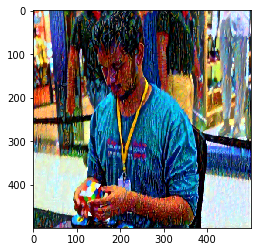

epoch:301 loss:2084.37353515625
epoch:302 loss:2076.060546875
epoch:303 loss:2067.800537109375
epoch:304 loss:2059.599853515625
epoch:305 loss:2051.453369140625
epoch:306 loss:2043.3560791015625
epoch:307 loss:2035.3099365234375
epoch:308 loss:2027.315185546875
epoch:309 loss:2019.378662109375
epoch:310 loss:2011.4918212890625
epoch:311 loss:2003.658203125
epoch:312 loss:1995.874755859375
epoch:313 loss:1988.1419677734375
epoch:314 loss:1980.4581298828125
epoch:315 loss:1972.82666015625
epoch:316 loss:1965.242431640625
epoch:317 loss:1957.7012939453125
epoch:318 loss:1950.210205078125
epoch:319 loss:1942.7713623046875
epoch:320 loss:1935.38232421875
epoch:321 loss:1928.034423828125
epoch:322 loss:1920.728271484375
epoch:323 loss:1913.475341796875
epoch:324 loss:1906.2630615234375
epoch:325 loss:1899.0985107421875
epoch:326 loss:1891.978759765625
epoch:327 loss:1884.902587890625
epoch:328 loss:1877.87353515625
epoch:329 loss:1870.8905029296875
epoch:330 loss:1863.94921875
epoch:331 loss

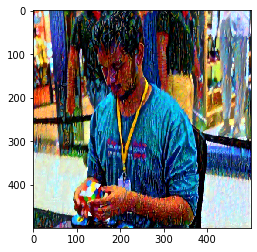

epoch:401 loss:1461.54541015625
epoch:402 loss:1458.0203857421875
epoch:403 loss:1454.476806640625
epoch:404 loss:1451.450439453125
epoch:405 loss:1446.880126953125
epoch:406 loss:1441.80419921875
epoch:407 loss:1435.4359130859375
epoch:408 loss:1430.179931640625
epoch:409 loss:1426.061767578125
epoch:410 loss:1422.5128173828125
epoch:411 loss:1418.9580078125
epoch:412 loss:1414.2432861328125
epoch:413 loss:1409.236572265625
epoch:414 loss:1404.130126953125
epoch:415 loss:1399.84326171875
epoch:416 loss:1396.0802001953125
epoch:417 loss:1392.1322021484375
epoch:418 loss:1388.056884765625
epoch:419 loss:1383.409423828125
epoch:420 loss:1378.957763671875
epoch:421 loss:1374.64404296875
epoch:422 loss:1370.6265869140625
epoch:423 loss:1366.7803955078125
epoch:424 loss:1362.771240234375
epoch:425 loss:1358.79736328125
epoch:426 loss:1354.5711669921875
epoch:427 loss:1350.4779052734375
epoch:428 loss:1346.3704833984375
epoch:429 loss:1342.405517578125
epoch:430 loss:1338.5238037109375
epoch

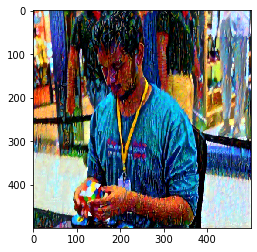

epoch:501 loss:1104.4573974609375
epoch:502 loss:1101.542236328125
epoch:503 loss:1098.7327880859375
epoch:504 loss:1096.0228271484375
epoch:505 loss:1093.440185546875
epoch:506 loss:1090.8287353515625
epoch:507 loss:1088.3958740234375
epoch:508 loss:1085.8111572265625
epoch:509 loss:1083.3916015625
epoch:510 loss:1080.6607666015625
epoch:511 loss:1078.023681640625
epoch:512 loss:1075.0810546875
epoch:513 loss:1072.2872314453125
epoch:514 loss:1069.4010009765625
epoch:515 loss:1066.682373046875
epoch:516 loss:1064.0013427734375
epoch:517 loss:1061.39501953125
epoch:518 loss:1058.855224609375
epoch:519 loss:1056.3125
epoch:520 loss:1053.8809814453125
epoch:521 loss:1051.4056396484375
epoch:522 loss:1049.08544921875
epoch:523 loss:1046.6488037109375
epoch:524 loss:1044.3463134765625
epoch:525 loss:1041.8240966796875
epoch:526 loss:1039.3941650390625
epoch:527 loss:1036.7200927734375
epoch:528 loss:1034.155517578125
epoch:529 loss:1031.4718017578125
epoch:530 loss:1028.9239501953125
epoch

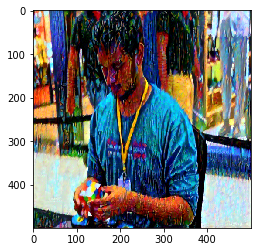

epoch:601 loss:880.5407104492188
epoch:602 loss:878.4378662109375
epoch:603 loss:876.4368286132812
epoch:604 loss:874.3564453125
epoch:605 loss:872.4483032226562
epoch:606 loss:870.6006469726562
epoch:607 loss:868.82861328125
epoch:608 loss:867.135986328125
epoch:609 loss:865.4440307617188
epoch:610 loss:863.881591796875
epoch:611 loss:862.2686767578125
epoch:612 loss:860.8069458007812
epoch:613 loss:859.1643676757812
epoch:614 loss:857.6298828125
epoch:615 loss:855.79443359375
epoch:616 loss:854.0328979492188
epoch:617 loss:852.0408935546875
epoch:618 loss:850.1759643554688
epoch:619 loss:848.2686157226562
epoch:620 loss:846.4986572265625
epoch:621 loss:844.7630615234375
epoch:622 loss:843.0790405273438
epoch:623 loss:841.4435424804688
epoch:624 loss:839.8126831054688
epoch:625 loss:838.28564453125
epoch:626 loss:836.7409057617188
epoch:627 loss:835.3651123046875
epoch:628 loss:833.9151611328125
epoch:629 loss:832.621826171875
epoch:630 loss:831.06494140625
epoch:631 loss:829.56201171

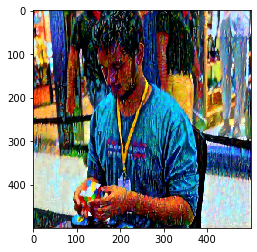

epoch:701 loss:729.494873046875
epoch:702 loss:728.5591430664062
epoch:703 loss:727.4760131835938
epoch:704 loss:726.491943359375
epoch:705 loss:725.1471557617188
epoch:706 loss:723.8165283203125
epoch:707 loss:722.197021484375
epoch:708 loss:720.71923828125
epoch:709 loss:719.2466430664062
epoch:710 loss:717.9457397460938
epoch:711 loss:716.72119140625
epoch:712 loss:715.5472412109375
epoch:713 loss:714.4672241210938
epoch:714 loss:713.388671875
epoch:715 loss:712.458251953125
epoch:716 loss:711.4453125
epoch:717 loss:710.5530395507812
epoch:718 loss:709.3814086914062
epoch:719 loss:708.2532958984375
epoch:720 loss:706.7914428710938
epoch:721 loss:705.4118041992188
epoch:722 loss:703.91015625
epoch:723 loss:702.5798950195312
epoch:724 loss:701.2969360351562
epoch:725 loss:700.1151733398438
epoch:726 loss:698.99755859375
epoch:727 loss:697.8997192382812
epoch:728 loss:696.9118041992188
epoch:729 loss:695.9161987304688
epoch:730 loss:695.0778198242188
epoch:731 loss:694.1137084960938
ep

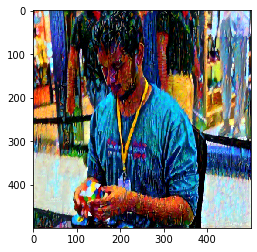

epoch:801 loss:622.2549438476562
epoch:802 loss:621.5467529296875
epoch:803 loss:621.0130004882812
epoch:804 loss:620.3453369140625
epoch:805 loss:619.7745361328125
epoch:806 loss:618.7666625976562
epoch:807 loss:617.76611328125
epoch:808 loss:616.4070434570312
epoch:809 loss:615.2068481445312
epoch:810 loss:613.9853515625
epoch:811 loss:612.9720458984375
epoch:812 loss:612.0494384765625
epoch:813 loss:611.203125
epoch:814 loss:610.4539184570312
epoch:815 loss:609.730224609375
epoch:816 loss:609.188232421875
epoch:817 loss:608.61865234375
epoch:818 loss:608.220947265625
epoch:819 loss:607.4940185546875
epoch:820 loss:606.751953125
epoch:821 loss:605.4851684570312
epoch:822 loss:604.282958984375
epoch:823 loss:602.9189453125
epoch:824 loss:601.811767578125
epoch:825 loss:600.8193359375
epoch:826 loss:599.9791259765625
epoch:827 loss:599.2509155273438
epoch:828 loss:598.5626220703125
epoch:829 loss:598.0301513671875
epoch:830 loss:597.4664916992188
epoch:831 loss:597.0487060546875
epoch:

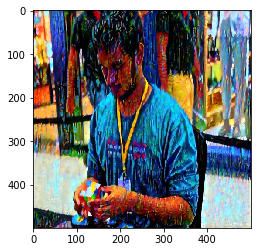

epoch:901 loss:543.835693359375
epoch:902 loss:542.9172973632812
epoch:903 loss:541.7711181640625
epoch:904 loss:540.815673828125
epoch:905 loss:539.917724609375
epoch:906 loss:539.1778564453125
epoch:907 loss:538.5178833007812
epoch:908 loss:537.9043579101562
epoch:909 loss:537.40185546875
epoch:910 loss:536.9279174804688
epoch:911 loss:536.6355590820312
epoch:912 loss:536.260009765625
epoch:913 loss:535.99462890625
epoch:914 loss:535.3489379882812
epoch:915 loss:534.6705932617188
epoch:916 loss:533.5392456054688
epoch:917 loss:532.5078125
epoch:918 loss:531.4209594726562
epoch:919 loss:530.5735473632812
epoch:920 loss:529.8435668945312
epoch:921 loss:529.2228393554688
epoch:922 loss:528.7130126953125
epoch:923 loss:528.2430419921875
epoch:924 loss:527.9295654296875
epoch:925 loss:527.5679321289062
epoch:926 loss:527.3327026367188
epoch:927 loss:526.791259765625
epoch:928 loss:526.22314453125
epoch:929 loss:525.1786499023438
epoch:930 loss:524.2006225585938
epoch:931 loss:523.09149169

In [19]:
optimizer = torch.optim.Adam([target_image], lr = 0.003)
epochs = 1000
loss = []
for epoch in range(epochs):
    
    targetcontent = getcontent(target_image, vgg, content_layers)
    targetstyle = [getstyle(content) for content in getcontent(target_image, vgg, style_layers)]
    
    style_loss = 0.0
    content_loss = torch.mean((targetcontent[4] - content[4])**2)
    for i in range(5):
        _,d,h,w = targetcontent[i].shape
        style_loss += (style_weights[i]*(torch.mean((targetstyle[i] - style[i])**2)))/(d*h*w)
    
    total_loss = alpha*content_loss + beta*style_loss
    optimizer.zero_grad()
    total_loss.backward(retain_graph = True)
    optimizer.step()
    print("epoch:{} loss:{}".format(epoch,total_loss.item()))
    if epoch%100 == 0:
        plt.imshow(convertimage(target_image))
        plt.show()

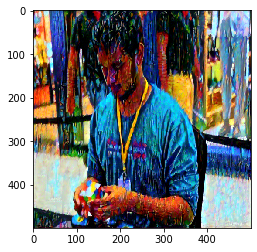

In [20]:
plt.imshow(convertimage(target_image))
plt.show()

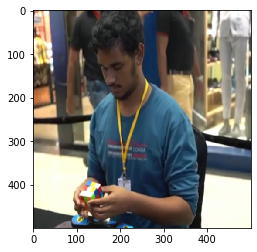

In [16]:
plt.imshow(convertimage(content_image))
plt.show()

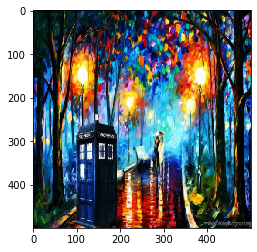

In [17]:
plt.imshow(convertimage(style_image))
plt.show()